In [48]:
import os
import pandas as pd
import matplotlib.pyplot as plt

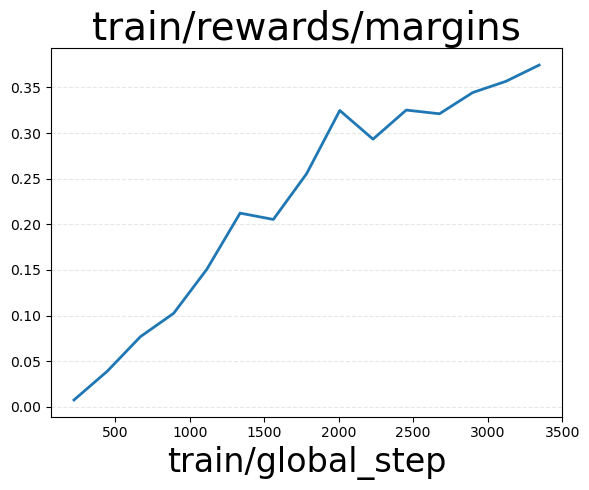

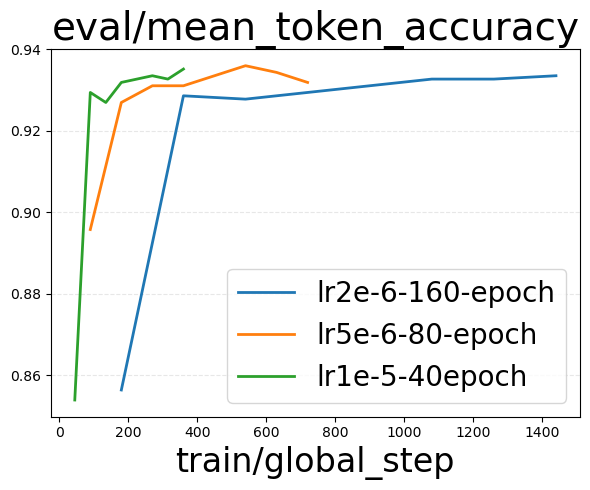

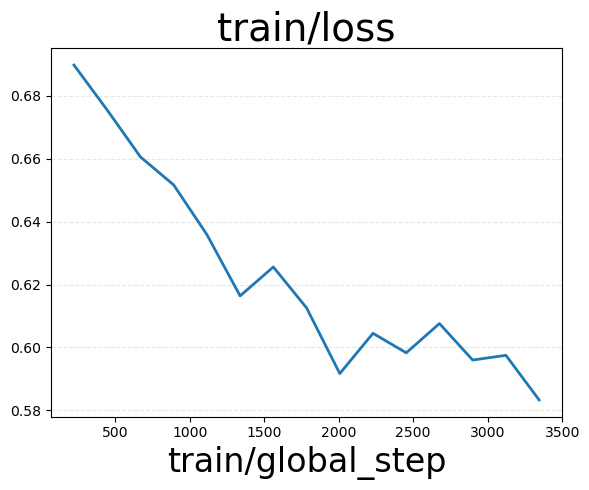

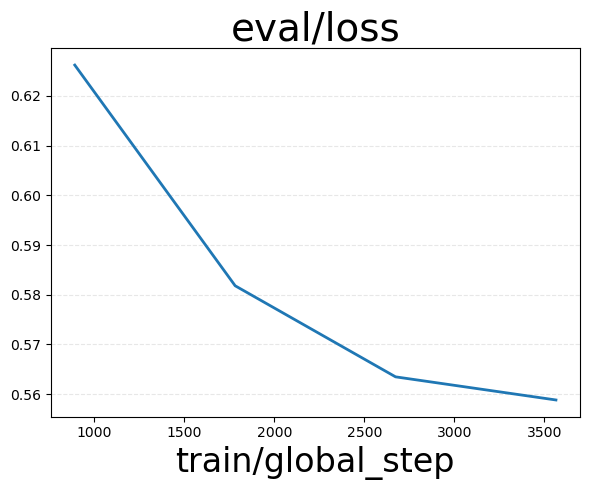

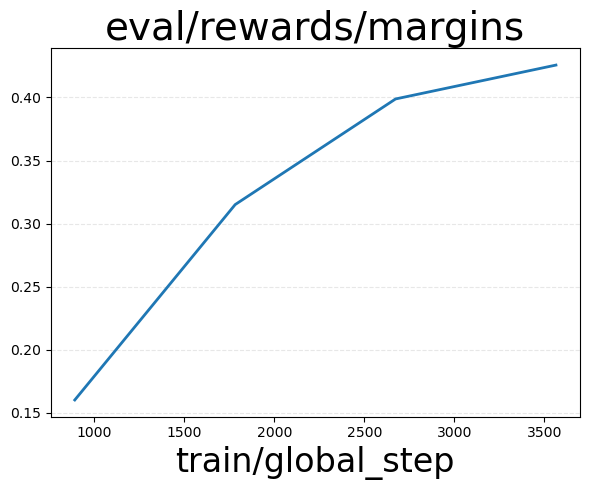

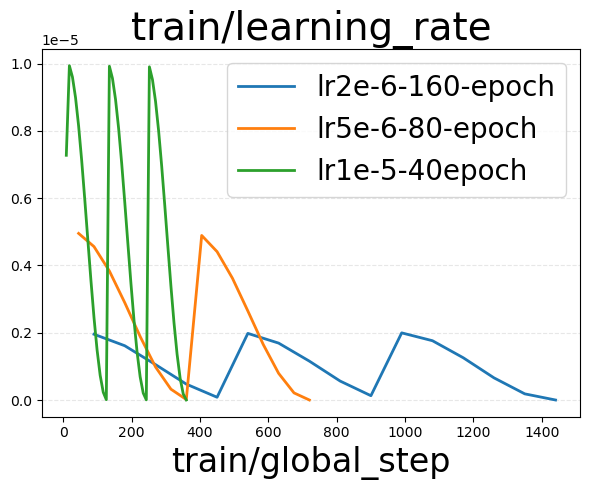

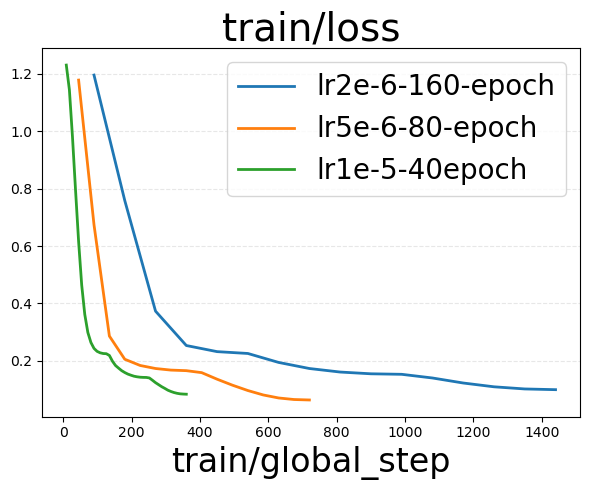

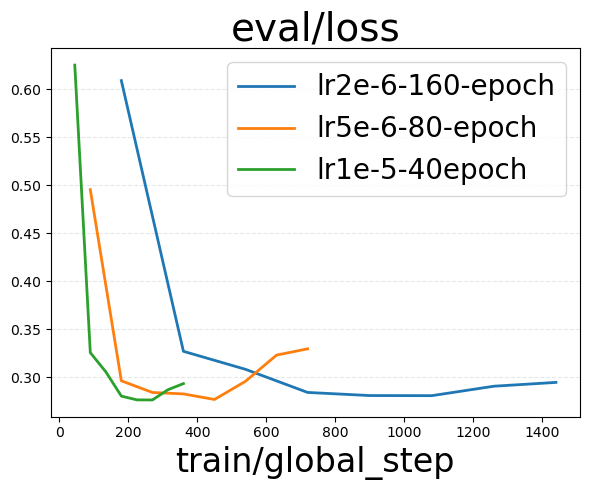

In [57]:
import os
import pandas as pd
import matplotlib.pyplot as plt

data_dir = "data"

csv_files = [f for f in os.listdir(data_dir) if f.endswith(".csv")]

for filename in csv_files:
    filepath = os.path.join(data_dir, filename)

    # ===== 1) 파일명 기반 metric 추출 =====
    parts = filename.replace(".csv", "").split("-")
    metric_path = "/".join(parts[1:])  # 두 번째 요소부터 끝까지
    metric_name = metric_path  # ex: eval/mean_token_accuracy

    # ===== 2) CSV 로드 =====
    df = pd.read_csv(filepath)

    # ===== 3) x축 (global step) =====
    if "train/global_step" not in df.columns:
        print(f"[WARN] train/global_step이 없는 파일: {filename}, 스킵")
        continue
    x = pd.to_numeric(df["train/global_step"], errors="coerce")

    # ===== 4) metric 컬럼 자동 탐색 =====
    # 패턴: "<run> - metric_name"
    target_cols = [
        col for col in df.columns
        if col.strip().endswith(metric_name)
        and "__" not in col  # MIN/MAX 제외
    ]

    if not target_cols:
        print(f"[WARN] metric '{metric_name}' 컬럼 없음 → 파일 스킵: {filename}")
        continue

    # ===== 5) plot 생성 =====
    plt.figure(figsize=(6, 5))

    for col in target_cols:
        run_name = col.replace(" - " + metric_name, "")
        y = pd.to_numeric(df[col], errors="coerce")
        data = pd.DataFrame({"x": x, "y": y}).dropna()

        if data.empty:
            continue

        plt.plot(data["x"], data["y"], label=run_name, linewidth=2)

    # ===== 6) 스타일 설정 =====
    plt.title(metric_name, fontsize=28)
    plt.xlabel("train/global_step", fontsize=24)

    if parts[0] == "sft":
        plt.legend(fontsize=20)

    plt.grid(axis="x", visible=False)
    plt.grid(axis="y", linestyle="--", alpha=0.3)

    plt.tight_layout()

    outpath = os.path.join("plots", filename.replace(".csv", ".png"))
    plt.savefig(outpath, dpi=200)